HW2

The data consists of 4 runs related closed eyes, open eyes, blinking, and clenching tasks:                                                                                            
each a 2 dimensional matrix: samples (2560) * channels (16)                                                                                                                             
Channels are as follows (ordered from 1 to 16) :                                                                                                                                        
1-FPz 2-Fz 3-T7 4-T8 5-C3 6-C4 7-C5 8-C6 9-CP3 10-CP4 11-Cz 12-CPz 13-Pz 14-PO7 15-PO8 16-Oz                                                                                            
sampling rate: 256 Hz,                                                                                                                                                                  
task duration: 1 min,                                                                                                                                                                   
number of channels: 16


In [1]:
import numpy as np
from scipy.io import loadmat
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch

type(matrices): <class 'list'> len(matrices): 5 type(matrices[0]): <class 'dict'>
matrices[0].keys(): dict_keys(['__header__', '__version__', '__globals__', 'data'])
<class 'numpy.ndarray'> (1, 1) 4
len(EyesOpen): 5 len(EyesClosed): 5 len(Blink): 5 len(Clench): 5
EyesOpen_np.shape: (5, 15360, 16) EyesClosed_np.shape: (5, 15360, 16) Blink_np.shape: (5, 15360, 16) Clench_np.shape: (5, 15360, 16)


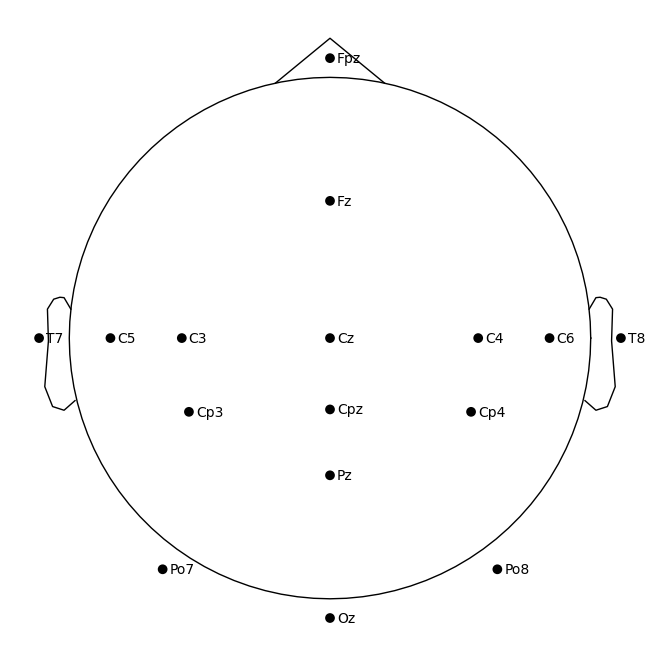

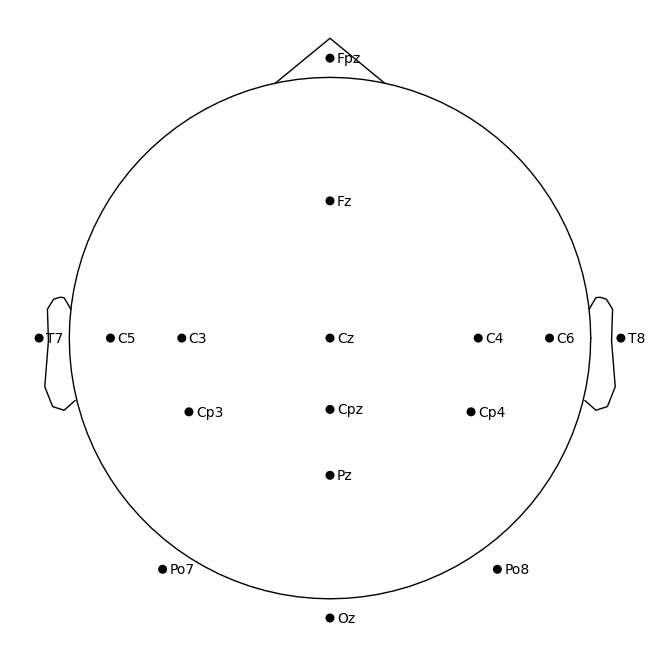

In [2]:
# 1. Load the .mat file
filenames = ["S1_data.mat", "S2_data.mat", "S3_data.mat", "S4_data.mat", "S5_data.mat"]
matrices = [loadmat(filename) for filename in filenames] 
print('type(matrices):', type(matrices), 'len(matrices):', len(matrices), 'type(matrices[0]):', type(matrices[0])) 
# type(matrices): <class 'list'> len(matrices): 5 type(matrices[0]): <class 'dict'>,
#So, matrices[i] refers to ith matrix
# Print the keys in the first loaded matrix
print('matrices[0].keys():', matrices[0].keys()) # matrices[0].keys(): dict_keys(['__header__', '__version__', '__globals__', 'data'])
#so matrices[i]['data'] refers to the data of the ith matrix
print(type(matrices[0]['data']), matrices[0]['data'].shape, len(matrices[0]['data'][0, 0])) #<class 'numpy.ndarray'> (1, 1) 4
#so, matrices[i]['data'][0, 0][j] refers to the jth array of the ith matrix with shape (15360, 16): EyesOpen(j=0), EyesClosed(j=1), Blink(j=2), Clench(j=3), i=0,... ,4
 
########################################################################################################################################################################
EyesOpen=[]
EyesClosed=[]
Blink=[]
Clench=[]
for i in range( len(matrices)):
    for j in range(len(matrices[0]['data'][0, 0])):
        if j==0:
            EyesOpen.append(matrices[i]['data'][0, 0][j])
        elif j==1:
            EyesClosed.append(matrices[i]['data'][0, 0][j])
        elif j==2:
            Blink.append(matrices[i]['data'][0, 0][j])
        else:
            Clench.append(matrices[i]['data'][0, 0][j])   

print('len(EyesOpen):', len(EyesOpen), 'len(EyesClosed):', len(EyesClosed), 'len(Blink):', len(Blink), 'len(Clench):', len(Clench))   
#len(EyesOpen): 5 len(EyesClosed): 5 len(Blink): 5 len(Clench): 5
EyesOpen_np=np.array(EyesOpen)
EyesClosed_np=np.array(EyesClosed)
Blink_np=np.array(Blink)
Clench_np=np.array(Clench)
print('EyesOpen_np.shape:', EyesOpen_np.shape, 'EyesClosed_np.shape:', EyesClosed_np.shape, 'Blink_np.shape:', Blink_np.shape, 'Clench_np.shape:', Clench_np.shape) 
#EyesOpen_np.shape: (5, 15360, 16) EyesClosed_np.shape: (5, 15360, 16) Blink_np.shape: (5, 15360, 16) Clench_np.shape: (5, 15360, 16)  

######################################################################################################################################
# Read the eloc16C2.txt
with open('eloc16C2.txt', 'r') as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]  # This removes any empty lines
# Check that you're only processing 16 lines
if len(lines) != 16:
    print(f"Warning: Expected 16 lines but found {len(lines)} lines.")
    for line in lines:
        print(line)  # This will print out all lines so you can inspect them
else:
    # Extract channel names, theta, and radius
    channel_names = [line.split()[3].replace('.', '') for line in lines]  
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)
# Plot the montage
montage.plot(show_names=True)

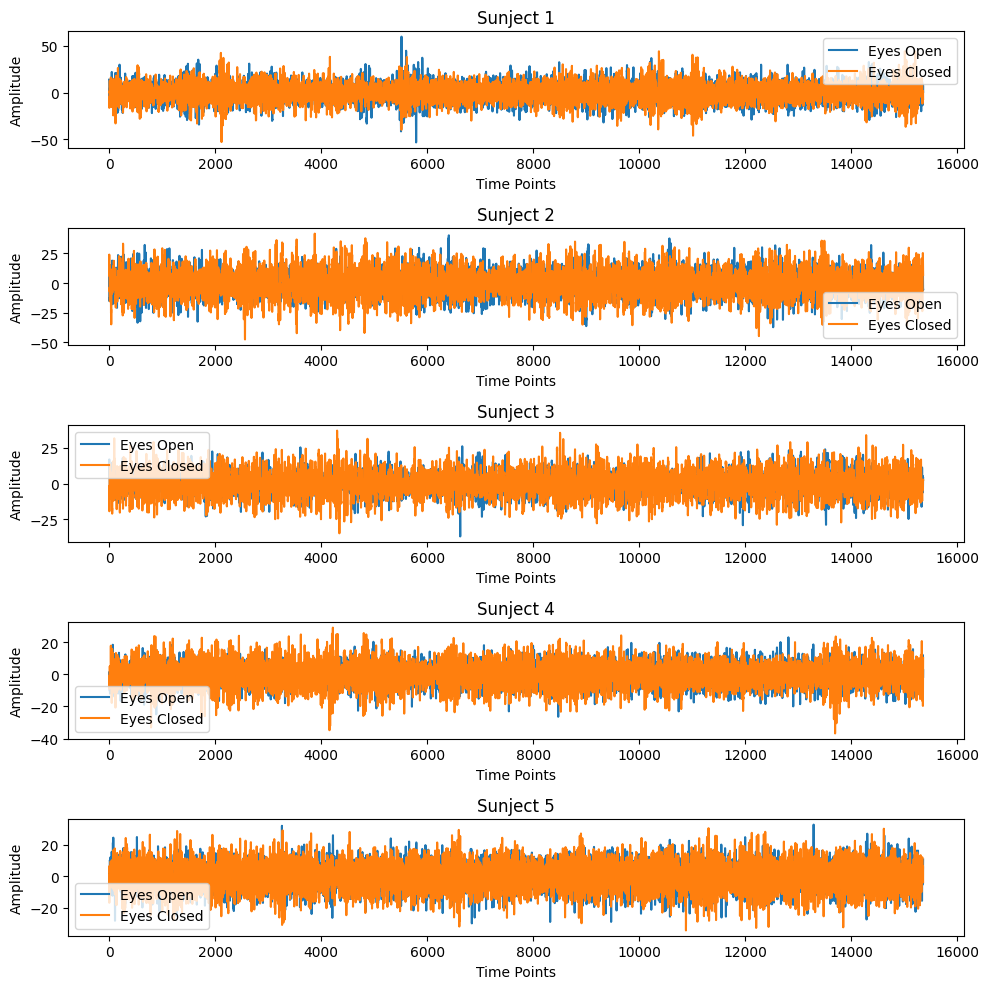

In [3]:
# Extract Oz channel data for each condition
eyes_open_oz = EyesOpen_np[:, :, 15]  # The 16th channel (0-based indexing)
eyes_closed_oz = EyesClosed_np[:, :, 15]
n_s = eyes_closed_oz.shape[0]
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(eyes_open_oz[i], label='Eyes Open')
    axes[i].plot(eyes_closed_oz[i], label='Eyes Closed')
    axes[i].set_title(f'Sunject {i + 1}')
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend()
plt.tight_layout()
plt.show()

(a) Compute the power spectral density (PSD) of the entire eyes open and eyes closed conditions 
for channel “Oz”

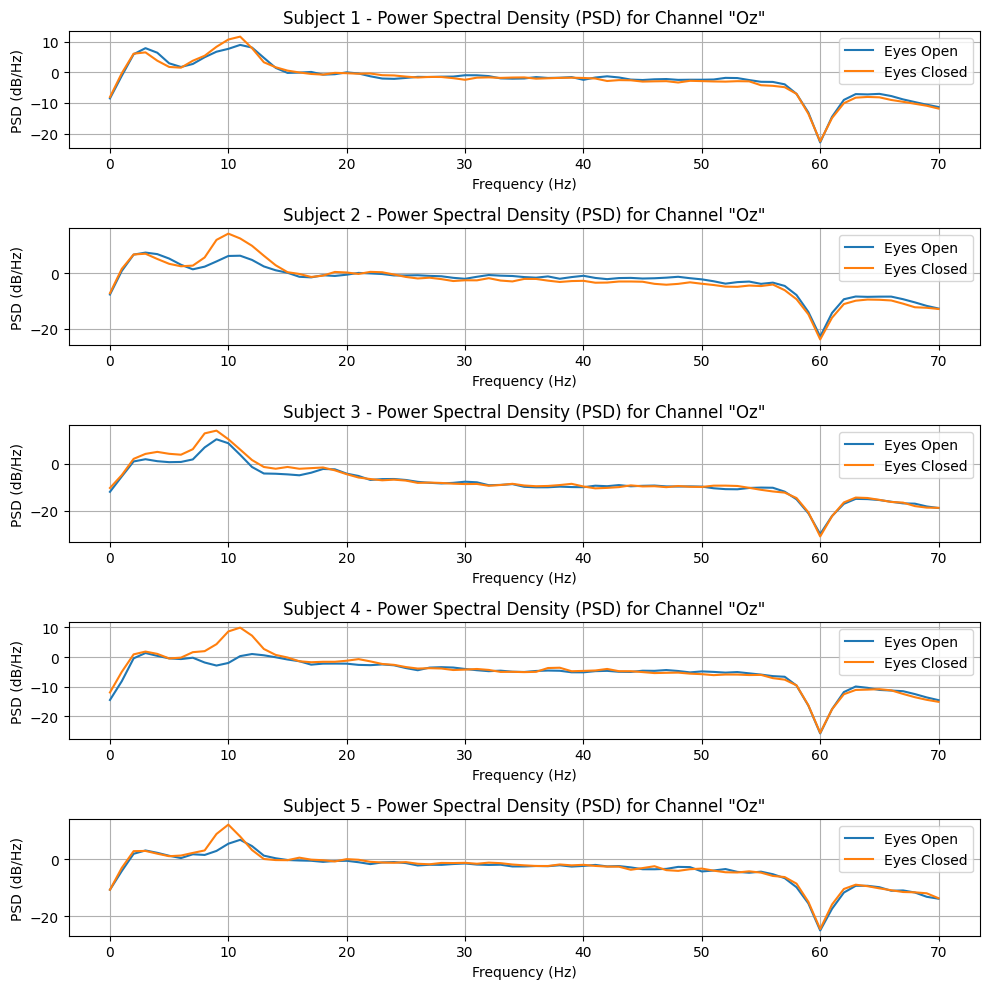

In [8]:
# a.
# Define the sampling frequency and parameters for the Welch method
fs = 256  # Given
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap

# Compute PSD for each subject
frequencies, psd_open = welch(eyes_open_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
_, psd_closed = welch(eyes_closed_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Filtering the frequencies and corresponding PSD values to be within the 0-70 Hz range
mask = (frequencies >= 0) & (frequencies <= 70)
filtered_frequencies = frequencies[mask]
filtered_psd_open = psd_open[:, mask]
filtered_psd_closed = psd_closed[:, mask]
psd_open_log=10*np.log10(filtered_psd_open)
psd_closed_log=10*np.log10(filtered_psd_closed)
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(psd_open_log[i], label='Eyes Open')
    axes[i].plot(psd_closed_log[i], label='Eyes Closed')
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Channel "Oz"')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')
plt.tight_layout()
plt.show()

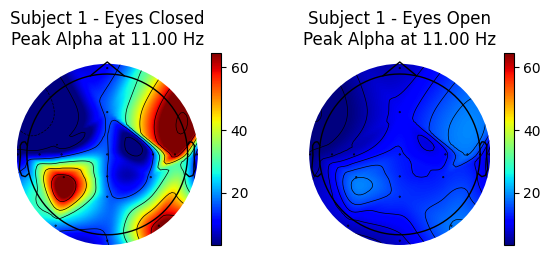

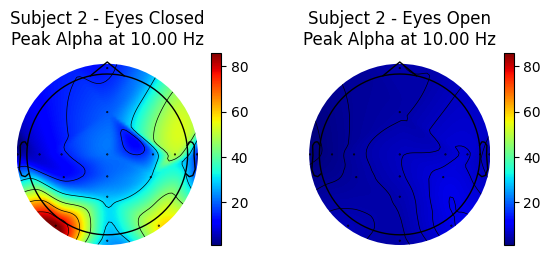

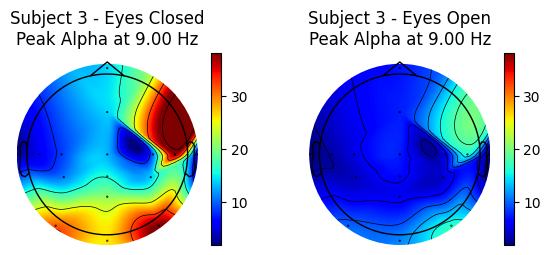

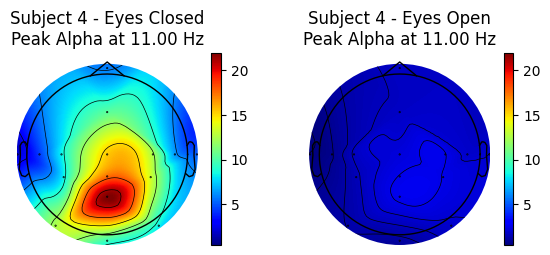

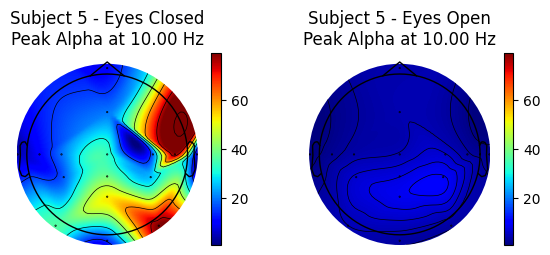

In [9]:
# b.
alpha_mask = (filtered_frequencies >= 8) & (filtered_frequencies <= 12)
alpha_psd = psd_closed_log[:, alpha_mask]
peak_alpha_indices = np.argmax(alpha_psd, axis=1)
peak_alpha_frequencies = filtered_frequencies[alpha_mask][peak_alpha_indices]
#peak_alpha_frequencies = array([11., 10.,  9., 11., 10.])

num_subjects, num_timepoints, num_channels = EyesOpen_np.shape # (5, 15360, 16)

# Preallocate arrays for storing the PSD data
psd_open_all = np.empty((num_subjects, num_channels, len(frequencies)))
psd_closed_all = np.empty((num_subjects, num_channels, len(frequencies)))

# Calculate the PSD for all channels and subjects
for channel in range(num_channels):
    _, psd_open_all[:, channel, :] = welch(EyesOpen_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
    _, psd_closed_all[:, channel, :] = welch(EyesClosed_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
    
    
# # Determine consistent color limits across subjects for each conditions
# global_closed=[]
# global_open=[]
# for subject in range(num_subjects):
#     peak_freq = peak_alpha_frequencies[subject]
#     # Extract PSD values at the peak alpha frequency for both eyes-open and eyes-closed conditions
#     closed_peak_psd_values = psd_closed_all[subject, :, frequencies == peak_freq].squeeze()
#     open_peak_psd_values = psd_open_all[subject, :, frequencies == peak_freq].squeeze()
#     global_closed.append(closed_peak_psd_values)
#     global_open.append(open_peak_psd_values)
# global_vmin_closed =np.min(global_closed)
# global_vmax_closed =np.max(global_closed)
# global_vmin_open =np.min(global_open)
# global_vmax_open =np.max(global_open)
# global_vmin_closed_log =10*np.log10(global_vmin_closed)
# global_vmax_closed_log =10*np.log10(global_vmax_closed)
# global_vmin_open_log =10*np.log10(global_vmin_open)
# global_vmax_open_log =10*np.log10(global_vmax_open)


for subject in range(num_subjects):
    # Extract the peak alpha frequency for this subject
    peak_freq = peak_alpha_frequencies[subject]
    # Extract PSD values at the peak alpha frequency for both eyes-open and eyes-closed conditions
    closed_peak_psd_values = psd_closed_all[subject, :, frequencies == peak_freq].squeeze()
    open_peak_psd_values = psd_open_all[subject, :, frequencies == peak_freq].squeeze()
    # Determine consistent color limits across conditions for each sunject
    global_vmin = min(np.min(closed_peak_psd_values), np.min(open_peak_psd_values))
    global_vmax = max(np.max(closed_peak_psd_values), np.max(open_peak_psd_values))
    # # Extract 10log10 PSD values at the peak alpha frequency for both eyes-open and eyes-closed conditions
    # closed_peak_psd_values_log=10*np.log10(closed_peak_psd_values)
    # open_peak_psd_values_log=10*np.log10(open_peak_psd_values)
    # # Determine consistent color limits across conditions for each sunject
    # global_vmin_log = min(np.min(closed_peak_psd_values_log), np.min(open_peak_psd_values))
    # global_vmax_log = max(np.max(closed_peak_psd_values_log), np.max(open_peak_psd_values))
    fig, axes = plt.subplots(1, 2, figsize=(6,2.5))
    # Eyes-closed condition
    im1, _ = mne.viz.plot_topomap(closed_peak_psd_values, info, cmap='jet', axes=axes[0], show=False)
    im1.set_clim(global_vmin, global_vmax)
    axes[0].set_title(f'Subject {subject + 1} - Eyes Closed\nPeak Alpha at {peak_freq:.2f} Hz')
    plt.colorbar(im1, ax=axes[0])
    # Eyes-open condition
    im2, _ = mne.viz.plot_topomap(open_peak_psd_values, info, cmap='jet', axes=axes[1], show=False)
    im2.set_clim(global_vmin, global_vmax)
    axes[1].set_title(f'Subject {subject + 1} - Eyes Open\nPeak Alpha at {peak_freq:.2f} Hz')
    plt.colorbar(im2, ax=axes[1])
    # # Eyes-closed condition log
    # im1, _ = mne.viz.plot_topomap(closed_peak_psd_values_log, info, cmap='jet', axes=axes[2], show=False)
    # im1.set_clim(global_vmin_log, global_vmax_log)
    # axes[2].set_title(f'Subject {subject + 1} - 10log10 Eyes Closed\nPeak Alpha at {peak_freq:.2f} Hz')
    # plt.colorbar(im1, ax=axes[2])
    # # Eyes-open condition log
    # im2, _ = mne.viz.plot_topomap(open_peak_psd_values_log, info, cmap='jet', axes=axes[3], show=False)
    # im2.set_clim(global_vmin_log, global_vmax_log)
    # axes[3].set_title(f'Subject {subject + 1} - 10log10 Eyes Open\nPeak Alpha at {peak_freq:.2f} Hz')
    # plt.colorbar(im2, ax=axes[3])
    plt.tight_layout()
    plt.show()


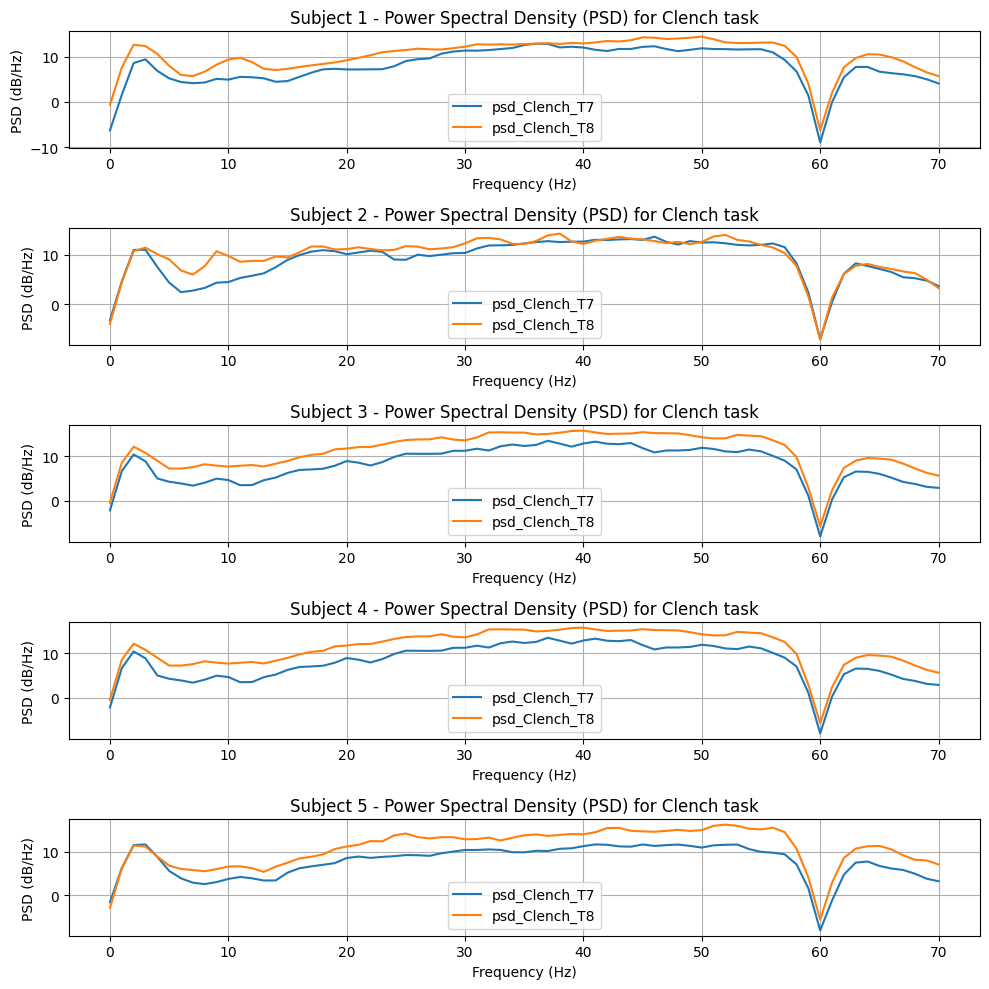

In [10]:
# c. 
# Extract channels “T7” and “T8 (2 and 3) data for each condition
Clench_np_T7 = Clench_np[:, :, 2]  
Clench_np_T8 = Clench_np[:, :, 3]
fs = 256  
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap

# Compute PSD for each subject
frequencies, psd_Clench_T7 = welch(Clench_np_T7, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
_, psd_Clench_T8 = welch(Clench_np_T8, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Filtering the frequencies and corresponding PSD values to be within the 0-70 Hz range
mask = (frequencies >= 0) & (frequencies <= 70)
filtered_frequencies = frequencies[mask]
filtered_psd_Clench_T7 = psd_Clench_T7[:, mask]
filtered_psd_Clench_T8 = psd_Clench_T8[:, mask]
psd_Clench_T7_log=10*np.log10(filtered_psd_Clench_T7)
psd_Clench_T8_log=10*np.log10(filtered_psd_Clench_T8)
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))

for i in range(n_s):
    axes[i].plot(psd_Clench_T7_log[i], label='psd_Clench_T7')
    axes[i].plot(psd_Clench_T8_log[i], label='psd_Clench_T8')
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Clench task')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')
plt.tight_layout()
plt.show()

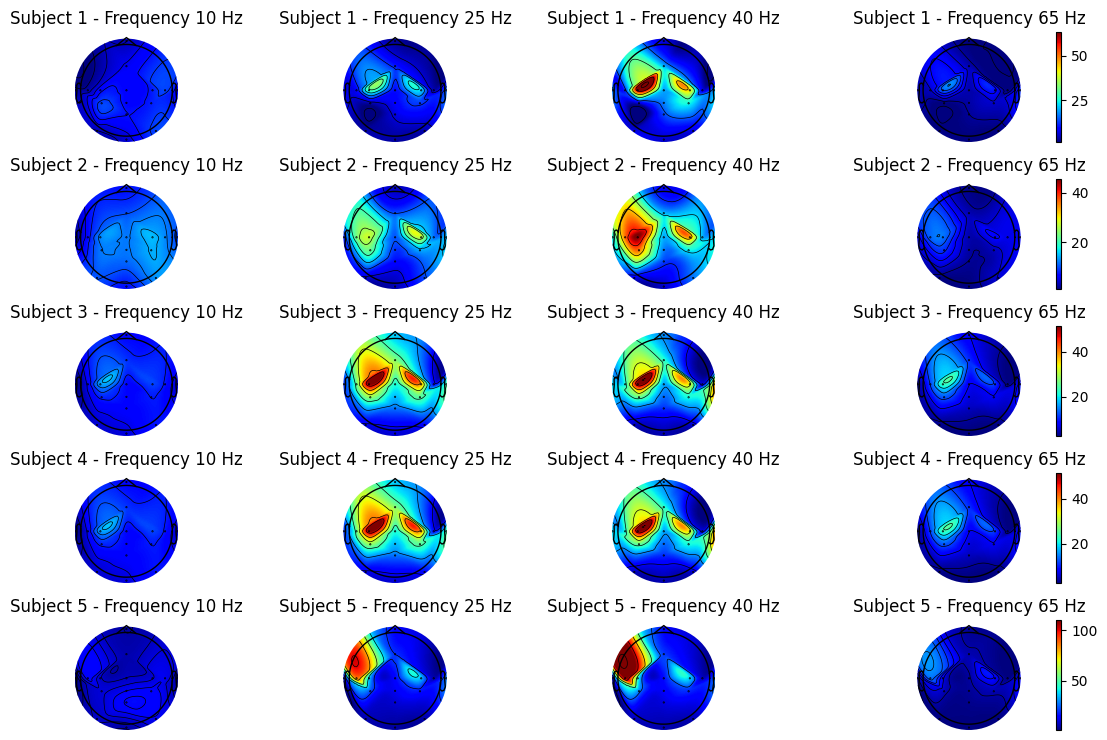

In [35]:
#d. 
# Preallocate arrays for storing the PSD data
PSD_Clench = np.empty((num_subjects, num_channels, len(frequencies)))
# psd_Clench_T8 = np.empty((num_subjects, num_channels, len(frequencies)))
clench_freq=[10, 25, 40, 65]
# Calculate the PSD for all channels and subjects
for channel in range(16):
    _, PSD_Clench[:, channel, :] = welch(Clench_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
    # _, psd_Clench_T8[:, channel, :] = welch(Clench_np_T8[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
fig, axes = plt.subplots(5, len(clench_freq), figsize=(3 * len(clench_freq), 1.5 * 5))
for subject in range(5):
    # Using a list comprehension to gather the PSD values for each frequency in clench_freq
    psd_values_for_freqs = [PSD_Clench[subject, :, frequencies == freq].squeeze() for freq in clench_freq]
    # Get global vmin and vmax for colorbar scaling for the current subject across all frequencies
    global_vmin = np.min(psd_values_for_freqs)
    global_vmax = np.max(psd_values_for_freqs)
    for idx, frequency in enumerate(clench_freq):
        clenched_psd_values = psd_values_for_freqs[idx]
        im, _ = mne.viz.plot_topomap(clenched_psd_values, info, cmap='jet', axes=axes[subject, idx], show=False)
        im.set_clim(global_vmin, global_vmax)
        axes[subject, idx].set_title(f'Subject {subject + 1} - Frequency {frequency} Hz')
    # Add individual colorbar for each subject at the rightmost column of the subplot array
    fig.colorbar(im, ax=axes[subject, -1], orientation='vertical', pad=0.1)
plt.tight_layout()
plt.show()